In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set(style='darkgrid')

from scipy.integrate import quad
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    # 'font.size'   : 40
})

%load_ext autoreload
%autoreload 2

# Import Dataset

In [3]:
ifmha = pd.read_csv('./dataset/ifmha_subset_stat.csv', converters={'site_no': str}, low_memory=False)

In [4]:
print(ifmha.shape)
ifmha['site_no'].value_counts().describe()

(2064782, 49)


count    6498.000000
mean      317.756540
std       269.268215
min        50.000000
25%       154.000000
50%       258.000000
75%       387.000000
max      6580.000000
Name: count, dtype: float64

In [5]:
candidate_columns = ['chan_width', 'chan_discharge', 'chan_area', 'SLOPE','chan_max_depth']
ifmha = ifmha[(ifmha[candidate_columns] > 0).all(axis=1)]
ifmha.shape

(2064720, 49)

In [6]:
# Trapezoid Cross-section
t1 = time.time()

# Side Slope (Ss):
ifmha_ss = ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)

# Bottom Width (Bw):
ifmha_bw =  ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).intercept_[0] * 2.0).reset_index(drop=False)

# Append Trapezoid Cross-section Parameters to IFMHA
ifmha = pd.merge(ifmha, ifmha_ss, how="left", on=["site_no"])
ifmha = pd.merge(ifmha, ifmha_bw, how="left", on=["site_no"])
print(time.time() - t1)

/var/folders/67/llrhzfgn4n3f59d6rnn20jmc0000gn/T/ipykernel_99952/2131555920.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ifmha_ss = ifmha.groupby("site_no").apply(lambda x: LinearRegression(positive=True).fit(x['chan_max_depth'].values.reshape(-1, 1), 0.5 * x['chan_width'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)
/var/folders/67/llrhzfgn4n3f59d6rnn20jmc0000gn/T/ipykernel_99952/2131555920.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the 

5.236440896987915


In [7]:
# Parabola Cross-section
t1 = time.time()

# Parabola Coefficient (a):
ifmha_a = ifmha.groupby("site_no").apply(lambda x: LinearRegression(fit_intercept=False).fit((0.5 * x['chan_width']**2).values.reshape(-1, 1), x['chan_max_depth'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)

# Append Parabola Cross-section Coefficient to IFMHA
ifmha = pd.merge(ifmha, ifmha_a, how="left", on=["site_no"])
print(time.time() - t1)

/var/folders/67/llrhzfgn4n3f59d6rnn20jmc0000gn/T/ipykernel_99952/304015123.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ifmha_a = ifmha.groupby("site_no").apply(lambda x: LinearRegression(fit_intercept=False).fit((0.5 * x['chan_width']**2).values.reshape(-1, 1), x['chan_max_depth'].values.reshape(-1, 1)).coef_[0,0]).reset_index(drop=False)


2.470409870147705


In [8]:
ifmha.rename(columns={'0_x': 'side_slope', '0_y': 'chan_bottom_width', 0:'parabola_coeff'}, inplace=True)

In [9]:
# Define the function for the parabolic curve y = ax^2
def parabola(x, a):
    return a * x**2

# Define the derivative of the parabolic curve
def derivative(x, a):
    return 2 * a * x

# Define the function for the integrand to calculate arc length
def integrand(x, a):
    return np.sqrt(1 + derivative(x, a)**2)

def cal_arc_length(func, x_min, x_max, a):
    # Calculate the arc length using quad (numerical integration)
    arc_length, _ = func(integrand, x_min, x_max, args=(a,))
    return arc_length

In [10]:
ifmha['arc_length'] = ifmha.apply(lambda x: cal_arc_length(quad, -x['chan_width'] / 2, x['chan_width'] / 2, x['parabola_coeff']), axis=1)

/var/folders/67/llrhzfgn4n3f59d6rnn20jmc0000gn/T/ipykernel_99952/4084398853.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  arc_length, _ = func(integrand, x_min, x_max, args=(a,))


In [11]:
# Exclude negative bottom width and steep side slope:
ifmha = ifmha[(ifmha['side_slope'] <= 12.0) & (ifmha['chan_bottom_width'] >= 0.0)]

# Estimate wetted perimeter based on Trapezoid cross-section
ifmha.loc[:, 'wetted_perimeter'] = ifmha['chan_bottom_width'] + (2 * ifmha['chan_max_depth'] * (1 + ifmha['side_slope']**2)**0.5)

In [12]:
print("dataset shape:", ifmha.shape)
ifmha['site_no'].value_counts().describe()

dataset shape: (1970542, 54)


count    6169.000000
mean      319.426487
std       271.648396
min        50.000000
25%       154.000000
50%       259.000000
75%       390.000000
max      6580.000000
Name: count, dtype: float64

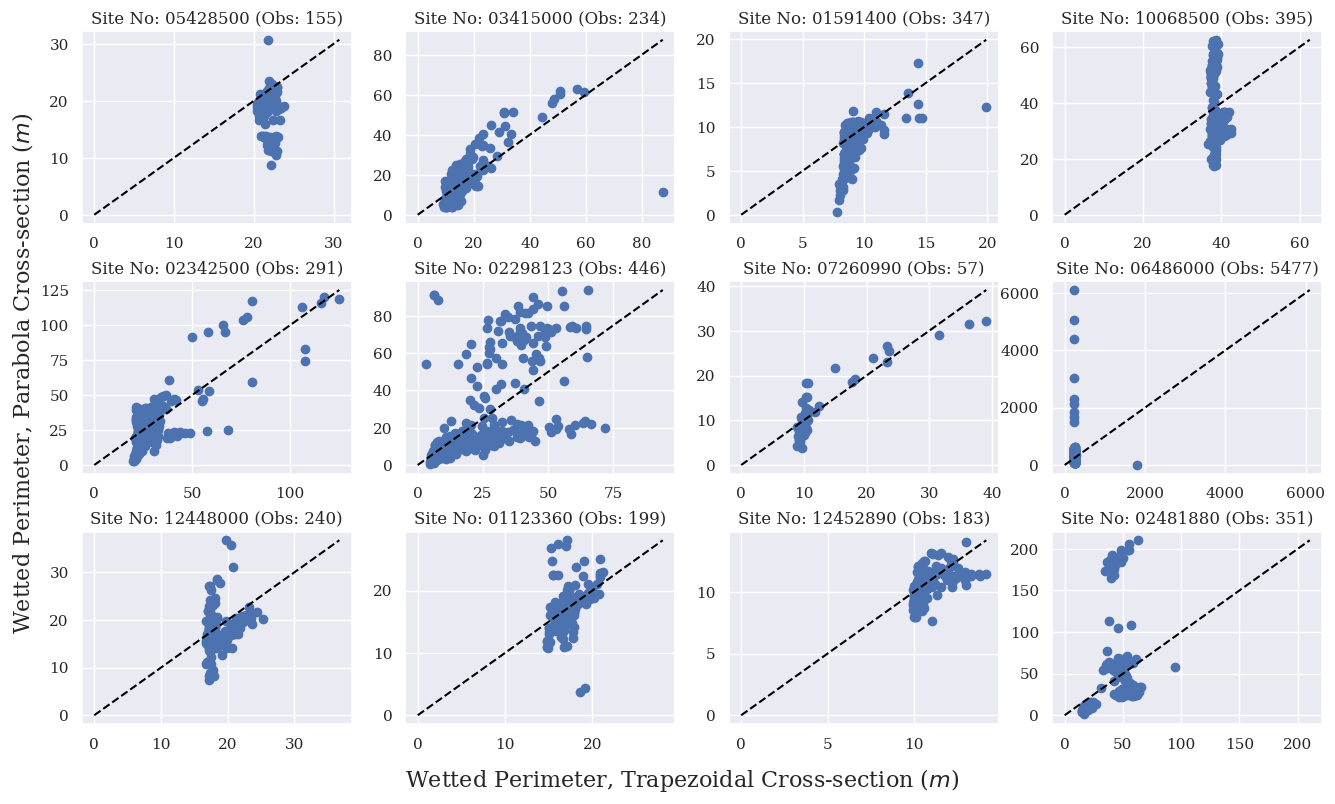

In [13]:
pct = False
grouped_ifmha = ifmha.groupby('site_no')

# Getting unique values from the grouped DataFrame
site_no = list(grouped_ifmha.groups.keys())

# Create a random number generator with seed 0
rng = np.random.default_rng(1)
# Generate 18 random number
random_sites = rng.choice(len(site_no), 18, replace=False).tolist()

fig, axes = plt.subplots(nrows=3, ncols=4 , figsize=(16, 9), constrained_layout=False)

fig.text(0.5, 0.04, r'Wetted Perimeter, Trapezoidal Cross-section ($m$)', ha='center', fontsize=16)
fig.text(0.08, 0.5, r'Wetted Perimeter, Parabola Cross-section ($m$)', va='center', rotation='vertical', fontsize=16)

for idx, sn in enumerate(random_sites[:12]):
    i, j = divmod(idx, 4)

    df = grouped_ifmha.get_group(site_no[sn])
    
    x = df["wetted_perimeter"] * 0.3048    # ft to m
    y = df["arc_length"] * 0.3048    # ft to m

    if pct:
        idx2 = x / y
        x = x[(idx2 > idx2.quantile(pct)) & (idx2 < idx2.quantile(1-pct))]
        y = y[(idx2 > idx2.quantile(pct)) & (idx2 < idx2.quantile(1-pct))]


    max_value = np.array((x, y)).max()
    
    axes[i, j].scatter(x, y)

    axes[i, j].plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)
    axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.f'))

    axes[i, j].set_title(f"Site No: {site_no[sn]} (Obs: {len(df)})")

# plt.legend(bbox_to_anchor=(1.4, 3.6))
plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

f = 'pdf'
plt.savefig(f'./wetted-perimeter-scplot.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [14]:
ifmha.loc[:, 'manning_roughness1'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['arc_length']**(2.0/3.0))
ifmha.loc[:, 'manning_roughness2'] = (1.49 * ifmha['SLOPE']**0.5 * ifmha['chan_area']**(5.0/3.0)) / (ifmha['chan_discharge'] * ifmha['wetted_perimeter']**(2.0/3.0))

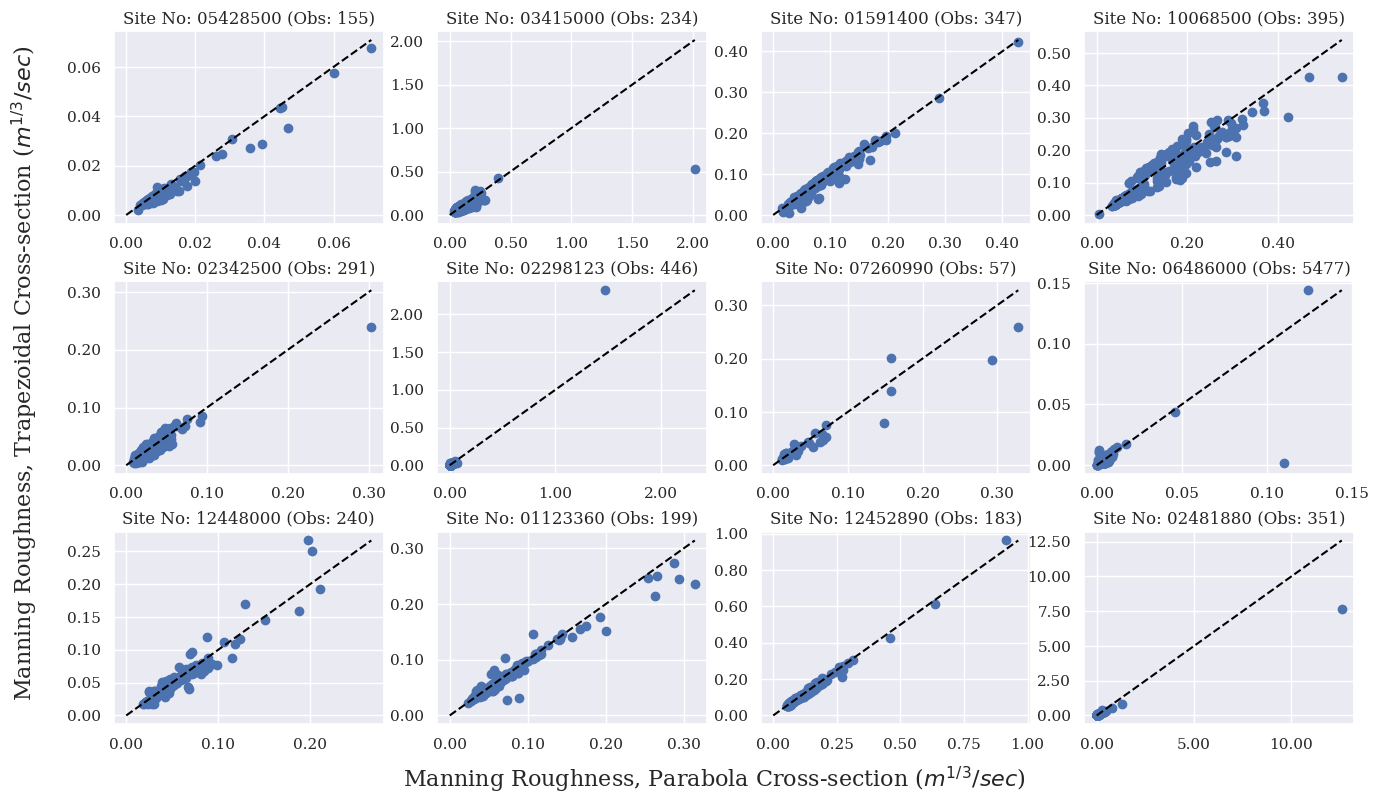

In [15]:

grouped_ifmha = ifmha.groupby('site_no')

# Getting unique values from the grouped DataFrame
site_no = list(grouped_ifmha.groups.keys())

# Create a random number generator with seed 0
rng = np.random.default_rng(1)
# Generate 18 random number
random_sites = rng.choice(len(site_no), 18, replace=False).tolist()

fig, axes = plt.subplots(nrows=3, ncols=4 , figsize=(16, 9), constrained_layout=False)

fig.text(0.5, 0.04, r'Manning Roughness, Parabola Cross-section ($m^{1/3}/sec$)', ha='center', fontsize=16)
fig.text(0.06, 0.5, r'Manning Roughness, Trapezoidal Cross-section ($m^{1/3}/sec$)', va='center', rotation='vertical', fontsize=16)

for idx, sn in enumerate(random_sites[:12]):
    i, j = divmod(idx, 4)

    df = grouped_ifmha.get_group(site_no[sn])
    
    x = df["manning_roughness1"] * 0.6204 # Imeperial to SI
    y = df["manning_roughness2"] * 0.6204 # Imeperial to SI

    if pct:

        idx2 = x / y
        x = x[(idx2 > idx2.quantile(pct)) & (idx2 < idx2.quantile(1-pct))]
        y = y[(idx2 > idx2.quantile(pct)) & (idx2 < idx2.quantile(1-pct))]

    max_value = np.array((x, y)).max()
    
    axes[i, j].scatter(x, y)

    axes[i, j].plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)
    axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axes[i, j].set_title(f"Site No: {site_no[sn]} (Obs: {len(df)})")

# plt.legend(bbox_to_anchor=(1.4, 3.6))
plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

f = 'pdf'
plt.savefig(f'./manning-roughness.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [56]:
def cal_r2_score(group):
    return r2_score(group.iloc[:, 0], group.iloc[:, 1])

data = ifmha.groupby('site_no')[['manning_roughness1', 'manning_roughness2']].apply(cal_r2_score).reset_index(drop=False) # 
data.loc[:, 'r2_wetted_perimeter'] = ifmha.groupby('site_no')[['arc_length', 'wetted_perimeter']].apply(cal_r2_score).values
data = data.rename(columns={0: 'r2_manning_roughness'})
data.head()

,site_no,r2_manning_roughness,r2_wetted_perimeter
0,01010000,0.498946,0.261297
1,01010070,0.953120,0.106603
2,01011000,0.852559,0.605936
3,01014000,0.771274,0.159529
4,01017000,0.790827,0.553966


In [16]:
df = ifmha.groupby('site_no')['manning_roughness1'].apply('median').reset_index(drop=False)
df.loc[:, 'manning_roughness2'] = ifmha.groupby('site_no')['manning_roughness2'].apply('median').values
df.head()

,site_no,manning_roughness1,manning_roughness2
0,01010000,0.101915,0.105527
1,01010070,0.069346,0.069677
2,01011000,0.056589,0.056064
3,01014000,0.004821,0.004851
4,01017000,0.019564,0.019551


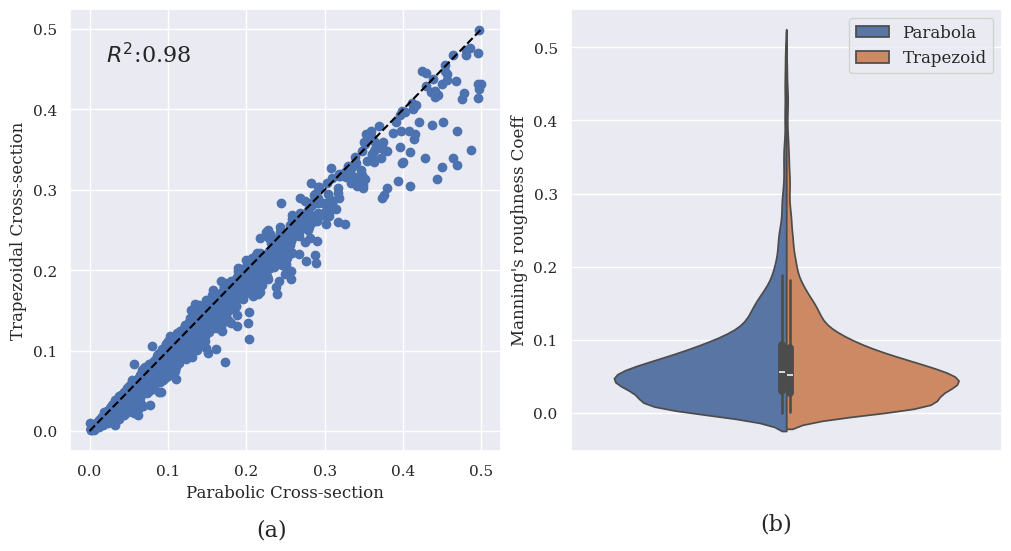

In [55]:
plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    # 'font.size'   : 40
})

# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 200}
#
# matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)


fig.text(0.25, -0.05, r'(a)', va='center', fontsize=16)
fig.text(0.77, -0.05, r'(b)', ha='center', fontsize=16)

data = df[(df[['manning_roughness1', 'manning_roughness2']] < 0.5).all(axis=1)]

max_value = np.max((data['manning_roughness1'].values, data['manning_roughness2'].values))

ax1.scatter(data['manning_roughness1'].values, data['manning_roughness2'].values)
ax1.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

ax1.set_xlabel('Parabolic Cross-section')
ax1.set_ylabel('Trapezoidal Cross-section')

r2 = r2_score(data['manning_roughness1'], data['manning_roughness2'])
fig.text(0.10, 0.90, rf'$R^2$:{r2:.2f}', va='center', fontsize=16)


data = data.rename(columns={'manning_roughness1': 'Parabola', 'manning_roughness2': 'Trapezoid'})
df2 = data.melt(value_vars=['Parabola', 'Trapezoid'], var_name='variable', value_name="Manning's roughness Coeff")

sns.violinplot(data=df2, y="Manning's roughness Coeff", hue='variable', split=True, ax=ax2)

# ax2.hist(data['manning_roughness1'].values, bins=30, alpha=0.7, label= "Parabola" )
# ax2.hist(data['manning_roughness2'].values, bins=30, alpha=0.5, label="Trapezoid")
ax2.legend(fontsize=12)

plt.savefig(f'./roughness.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()